# Yelp Affluence Cluster Model - K-Means 1/14/19
### Britt Allen, Bernard Kurka, Tom Ludlow

In [5]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
#Reading files
yelp = pd.read_csv('../Data/nyc_best.csv',dtype={'zip': 'str'})
irs = pd.read_csv('../final_irs_data.csv',dtype={'zipcode': 'str'})

#building a final df with irs + yelp 
irs = irs[['zipcode','affluence']]
#joining data frames
data = yelp.merge(irs, how='left', left_on='zip', right_on='zipcode')
#dop
data.drop('zipcode',axis=1,inplace=True)

In [54]:
data.head()

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,rv_4,avg_lat,avg_long,affluence
0,10001,New York,NY,NaN,17,20139,64,73672,12,13352,4,6783,40.751380,-73.991945,163.503168
1,10002,New York,NY,NaN,29,26811,64,87914,6,5705,0,0,40.719674,-73.989291,56.616311
2,10003,New York,NY,NaN,21,28355,64,115635,9,13478,5,7834,40.730335,-73.989247,239.728018
3,10004,New York,NY,NaN,21,38197,52,113225,13,16930,5,5147,40.715223,-73.999469,340.068952
4,10005,New York,NY,NaN,22,4917,61,21109,9,2624,3,1330,40.706818,-74.008856,543.720875


In [55]:
data.shape

(278, 15)

### Creating new features

In [56]:
data['pr_2m'] = data['pr_2'] * 2
data['pr_3m'] = data['pr_3'] * 3
data['pr_4m'] = data['pr_4'] * 4

In [57]:
data['pr_tot'] = data['pr_1'] + data['pr_2'] + data['pr_3'] + data['pr_4']
data['rv_tot'] = data['rv_1'] + data['rv_2'] + data['rv_3'] + data['rv_4']
data['pr_totm'] = data['pr_1'] + data['pr_2m'] + data['pr_3m'] + data['pr_4m']

In [58]:
features = ['pr_1','rv_1','pr_2','pr_2m','rv_2',
            'pr_3','pr_3m','rv_3','pr_4','pr_4m',
            'rv_4','pr_tot','rv_tot','pr_totm']


### Scaling features

In [59]:
ss = StandardScaler()

In [60]:
data_feat_ss = ss.fit_transform(data[features])

C:\Users\berku\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\berku\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Adding scaled features to DF

In [61]:
ss_feat = ['pr_1s','rv_1s','pr_2s','pr_2ms','rv_2s',
           'pr_3s','pr_3ms','rv_3s','pr_4s','pr_4ms',
           'rv_4s','pr_tots','rv_tots','pr_totms']


for col in ss_feat:
    data[col] = 0

data[ss_feat] = data_feat_ss

In [62]:
data.head()

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,rv_2s,pr_3s,pr_3ms,rv_3s,pr_4s,pr_4ms,rv_4s,pr_tots,rv_tots,pr_totms
0,10001,New York,NY,NaN,17,20139,64,73672,12,13352,...,2.367155,1.058714,1.058714,1.779857,0.879282,0.879282,1.625275,0.673113,2.334525,0.964115
1,10002,New York,NY,NaN,29,26811,64,87914,6,5705,...,2.976908,0.115373,0.115373,0.454949,-0.608939,-0.608939,-0.380241,0.736374,2.510417,0.611051
2,10003,New York,NY,NaN,21,28355,64,115635,9,13478,...,4.163747,0.587043,0.587043,1.801688,1.251337,1.251337,1.936022,0.736374,3.727667,0.948067
3,10004,New York,NY,NaN,21,38197,52,113225,13,16930,...,4.060566,1.215937,1.215937,2.399777,1.251337,1.251337,1.141562,0.483331,3.950028,0.755486
4,10005,New York,NY,NaN,22,4917,61,21109,9,2624,...,0.116739,0.587043,0.587043,-0.078861,0.507226,0.507226,0.012998,0.609852,0.056766,0.739438


In [63]:
data.columns

Index(['zip', 'city', 'state', 'cat', 'pr_1', 'rv_1', 'pr_2', 'rv_2', 'pr_3',
       'rv_3', 'pr_4', 'rv_4', 'avg_lat', 'avg_long', 'affluence', 'pr_2m',
       'pr_3m', 'pr_4m', 'pr_tot', 'rv_tot', 'pr_totm', 'pr_1s', 'rv_1s',
       'pr_2s', 'pr_2ms', 'rv_2s', 'pr_3s', 'pr_3ms', 'rv_3s', 'pr_4s',
       'pr_4ms', 'rv_4s', 'pr_tots', 'rv_tots', 'pr_totms'],
      dtype='object')

In [64]:
features = ['pr_1s','rv_1s','pr_2ms','rv_2s','pr_3ms',
            'rv_3s','pr_4ms','rv_4s','pr_tots','rv_tots',
            'pr_totms']#,'avg_lat','avg_long']

# Model and Feature Grid Search

### Mega Grid Search Function

In [65]:
def grid_clusters(df_dic, par_dic):
    result_dic = {"Data_frame" :[],
                  "model": [],
                  "inertia": [],
                  "silhouette": [],
                  "Numb_clusters": [],
                  "Cluster_counts": [],
                  "init": [],
                  "model_params": []
                  }
    # loop dataFrames
    for df_name, df_data in df_dic.items():
        X = df_data

        # loop models
        for n_model in par_dic.keys():
            if n_model == "kmeans":
                # loop centroid seeds
                for n_init_seed in par_dic['kmeans']['init_seed']:
                    # loop Method for initialization
                    for n_init_method in par_dic['kmeans']['inits']:
                        # loop algorithms
                        for n_algorithm in par_dic['kmeans']['algorithms']:
                            # loop number of clusters
                            for n_cluster in par_dic['kmeans']['clusters_list']:
                                kmeans = KMeans(n_clusters=n_cluster,
                                                init=n_init_method,
                                                n_init=n_init_seed,
                                                algorithm=n_algorithm,
                                                tol=par_dic['kmeans']['tol'],
                                                random_state=42)
                                kmeans.fit(X)
                                #Saving results in dic
                                result_dic['Data_frame'].append(df_name)
                                result_dic['model'].append(n_model)
                                result_dic['inertia'].append(kmeans.inertia_)
                                result_dic['silhouette'].append(silhouette_score(X, kmeans.labels_))
                                result_dic['Numb_clusters'].append(n_cluster)
                                result_dic['Cluster_counts'].append(list(pd.Series(kmeans.labels_).value_counts()))
                                result_dic['init'].append(n_init_seed)
                                result_dic['model_params'].append(kmeans)

            if n_model == "hierarchy":
                # loop linkage_method
                for n_link_met in par_dic['hierarchy']['linkage_method']:
                    for n_clusters in par_dic['hierarchy']['t']:
                        for n_crit in par_dic['hierarchy']['criterion']:
                            z = hierarchy.linkage(X, method=n_link_met)
                            cls = hierarchy.fcluster(z, n_clusters, "maxclust")
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, cls))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(cls).value_counts()))
                            result_dic['init'].append(0)
                            result_dic['model_params'].append("linkage_method:" + str(n_link_met))
            if n_model == "Agglomerative":
                # loop linkage criterion
                for n_link_met in par_dic['Agglomerative']['linkage_method']:
                    #loop number of clusters
                    for n_clusters in par_dic['Agglomerative']['clusters_list']:
                        # loop method to compute linkage
                        for n_affinity in par_dic['Agglomerative']['affinity']:
                            ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
                            ac.fit(X)
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, ac.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(ac.labels_).value_counts()))
                            result_dic['init'].append(0)
                            result_dic['model_params'].append(ac)
    return pd.DataFrame(result_dic)

### Generating model parameters for grid search

In [66]:
model_dic = {"kmeans": {"init_seed": [10,15,20],
                  "inits"  :  ["k-means++","random"],
                  "algorithms": ["auto"],
                  "clusters_list": range(4,10),
                  "tol": 0.0001},
       "hierarchy": {"linkage_method":['complete','ward', 'single',
                                       'centroid','median','weighted'],
                     "t": range(4,10),
                     "criterion": "maxclust"},
       "Agglomerative": {"linkage_method":['complete', 'single', #ward,
                                           'centroid','median','weighted'],
                         "affinity": ['euclidean', 'l1', 'l2', 'manhattan',
                                      'cosine', 'precomputed'],
                         "clusters_list": range(4,10)}
      }

### Generating features for grid search

In [67]:
all_features = ['pr_1s', 'rv_1s', 'pr_2ms', 'rv_2s', 'pr_3ms', 'rv_3s',
                'pr_4ms', 'rv_4s', 'pr_tots', 'rv_tots', 'pr_totms']
raw_prices = ['pr_1','pr_2','pr_3','pr_4']
sc_prices = ['pr_1s','pr_2s','pr_3s','pr_4s']
sc_multip_prices = ['pr_1s','pr_2ms','pr_3ms','pr_4ms']
sc_multip_prices_w_tot  = ['pr_1s','pr_2ms','pr_3ms','pr_4ms','pr_totms']



df_dic = {'All_features': data[all_features], 'Raw_prices': data[raw_prices],
         'scaled_prices': data[sc_prices],'scaled_pr_mult': data[sc_multip_prices],
         'scaled_pr_mult_wtot': data[sc_multip_prices_w_tot]
         }

In [68]:
## Running grid search and saving results in pd Data Frame
result = grid_clusters(df_dic,model_dic)
result.shape

(2520, 8)

In [70]:
# Top 5 silhouette
result.sort_values(by=['silhouette'],ascending = False).head(1)

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,init,model_params
133,All_features,hierarchy,0.0,0.532652,4,"[270, 4, 3, 1]",0,linkage_method:single


In [75]:
# Top hierarchy silhouette score
display(result[(result.model == 'hierarchy')]\
.sort_values(by=['silhouette'],ascending = False).head(1))

# Top agglomerative silhouette score
display(result[(result.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(1))

# Top kmeans silhouette score
display(result[(result.model == 'kmeans')]\
.sort_values(by=['inertia'],ascending = True).sort_values(by=['silhouette'],ascending = False).head(1))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,init,model_params
135,All_features,hierarchy,0.0,0.532652,4,"[270, 4, 3, 1]",0,linkage_method:single


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,init,model_params
829,Raw_prices,Agglomerative,0.0,0.454304,4,"[94, 82, 70, 32]",0,"AgglomerativeClustering(affinity='euclidean', ..."


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,init,model_params
18,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",15,"KMeans(algorithm='auto', copy_x=True, init='ra..."


#### Results
1. The hierarchy with k=4 had the highest silhouette score but 3 of the clusters have only 1 observation.[207,1 ,1, 1]
2. Agglomerative and K Means with with k=4 had similar results,good silhouette score and better cluster count distribution.
3. We chose to further explore the K Means model.


### Comparing K Means scores with different features selections

In [76]:
result[(result.model == 'kmeans') & (result.Numb_clusters==4)]\
.sort_values(by=['inertia'],ascending = True).sort_values(by=['silhouette'],ascending = False)

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,init,model_params
0,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",10,"KMeans(algorithm='auto', copy_x=True, init='k-..."
6,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",10,"KMeans(algorithm='auto', copy_x=True, init='ra..."
12,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",15,"KMeans(algorithm='auto', copy_x=True, init='k-..."
18,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",15,"KMeans(algorithm='auto', copy_x=True, init='ra..."
24,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",20,"KMeans(algorithm='auto', copy_x=True, init='k-..."
30,All_features,kmeans,821.913495,0.484193,4,"[150, 72, 35, 21]",20,"KMeans(algorithm='auto', copy_x=True, init='ra..."
504,Raw_prices,kmeans,35925.289415,0.473452,4,"[98, 73, 64, 43]",10,"KMeans(algorithm='auto', copy_x=True, init='k-..."
510,Raw_prices,kmeans,35925.289415,0.473452,4,"[98, 73, 64, 43]",10,"KMeans(algorithm='auto', copy_x=True, init='ra..."
516,Raw_prices,kmeans,35925.289415,0.473452,4,"[98, 73, 64, 43]",15,"KMeans(algorithm='auto', copy_x=True, init='k-..."
522,Raw_prices,kmeans,35925.289415,0.473452,4,"[98, 73, 64, 43]",15,"KMeans(algorithm='auto', copy_x=True, init='ra..."


#### Taking into account a balance between Inertia and Silluete score we selected to use the following features:
```scaled_pr_mult_wtot = ['pr_1s', 'pr_2ms', 'pr_3ms', 'pr_4ms', 'pr_totms']```

In [101]:
# Hyper parameters chosen:
kmeans4scaled_pr_mult_wtot = KMeans(n_clusters=4,algorithm='auto',init='random',random_state=42)
model4scaled_pr_mult_wtot = kmeans4scaled_pr_mult_wtot.fit(data[sc_multip_prices_w_tot])
data['kmeans4scaled_pr_mult_wtot'] = model4scaled_pr_mult_wtot.labels_
print("Final model silhuete", silhouette_score(data[sc_multip_prices_w_tot],model4scaled_pr_mult_wtot.labels_))
print("Final model Inertia", model4scaled_pr_mult_wtot.inertia_)

print("\nFinal model Cluster Count\n")

print(data['kmeans4scaled_pr_mult_wtot'].value_counts(sort=False))

print("\n\nFinal model IRS median affluence per cluster:")
display(data.groupby(['kmeans4scaled_pr_mult_wtot'])['affluence'].agg([max,min,np.mean,np.median]))

Final model silhuete 0.4300944659058705
Final model Inertia 308.7537980715292

Final model Cluster Count

0    71
1    45
2    80
3    82
Name: kmeans4scaled_pr_mult_wtot, dtype: int64


Final model IRS median affluence per cluster:


,max,min,mean,median
kmeans4scaled_pr_mult_wtot,,,,
0,189.555172,42.220250,70.100842,43.323226
1,532.244589,84.271991,313.972958,291.441972
2,720.303448,26.893245,59.708185,46.318720
3,893.201744,26.752952,109.952328,70.327460


In [47]:
#result.groupby(['model','Numb_clusters'])['inertia','silhouette'].agg([max,min,np.mean,np.median])

## Checking number of Cluster using the elbow method

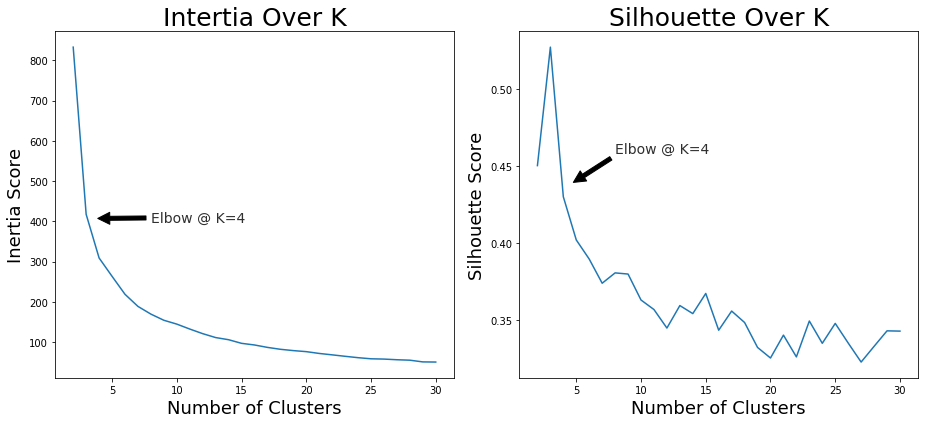

In [80]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(data[sc_multip_prices_w_tot])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
ax[0].annotate('Elbow @ K=4', xy = (0.10, .46),  xycoords = 'axes fraction', \
    xytext = (0.24, 0.45), fontsize = 14, \
    color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[1].annotate('Elbow @ K=4', xy = (0.13, .56),  xycoords = 'axes fraction', \
    xytext = (0.24, 0.65), fontsize = 14, \
    color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Intertia Over K',fontsize = 25)
ax[1].set_title('Silhouette Over K',fontsize = 25)
ax[0].set_xlabel('Number of Clusters', size = 18)
ax[1].set_xlabel('Number of Clusters', size = 18)
ax[0].set_ylabel('Inertia Score', size = 18)
ax[1].set_ylabel('Silhouette Score', size = 18)

fig.tight_layout()

## Analizing Scatter Plots per each Cluster

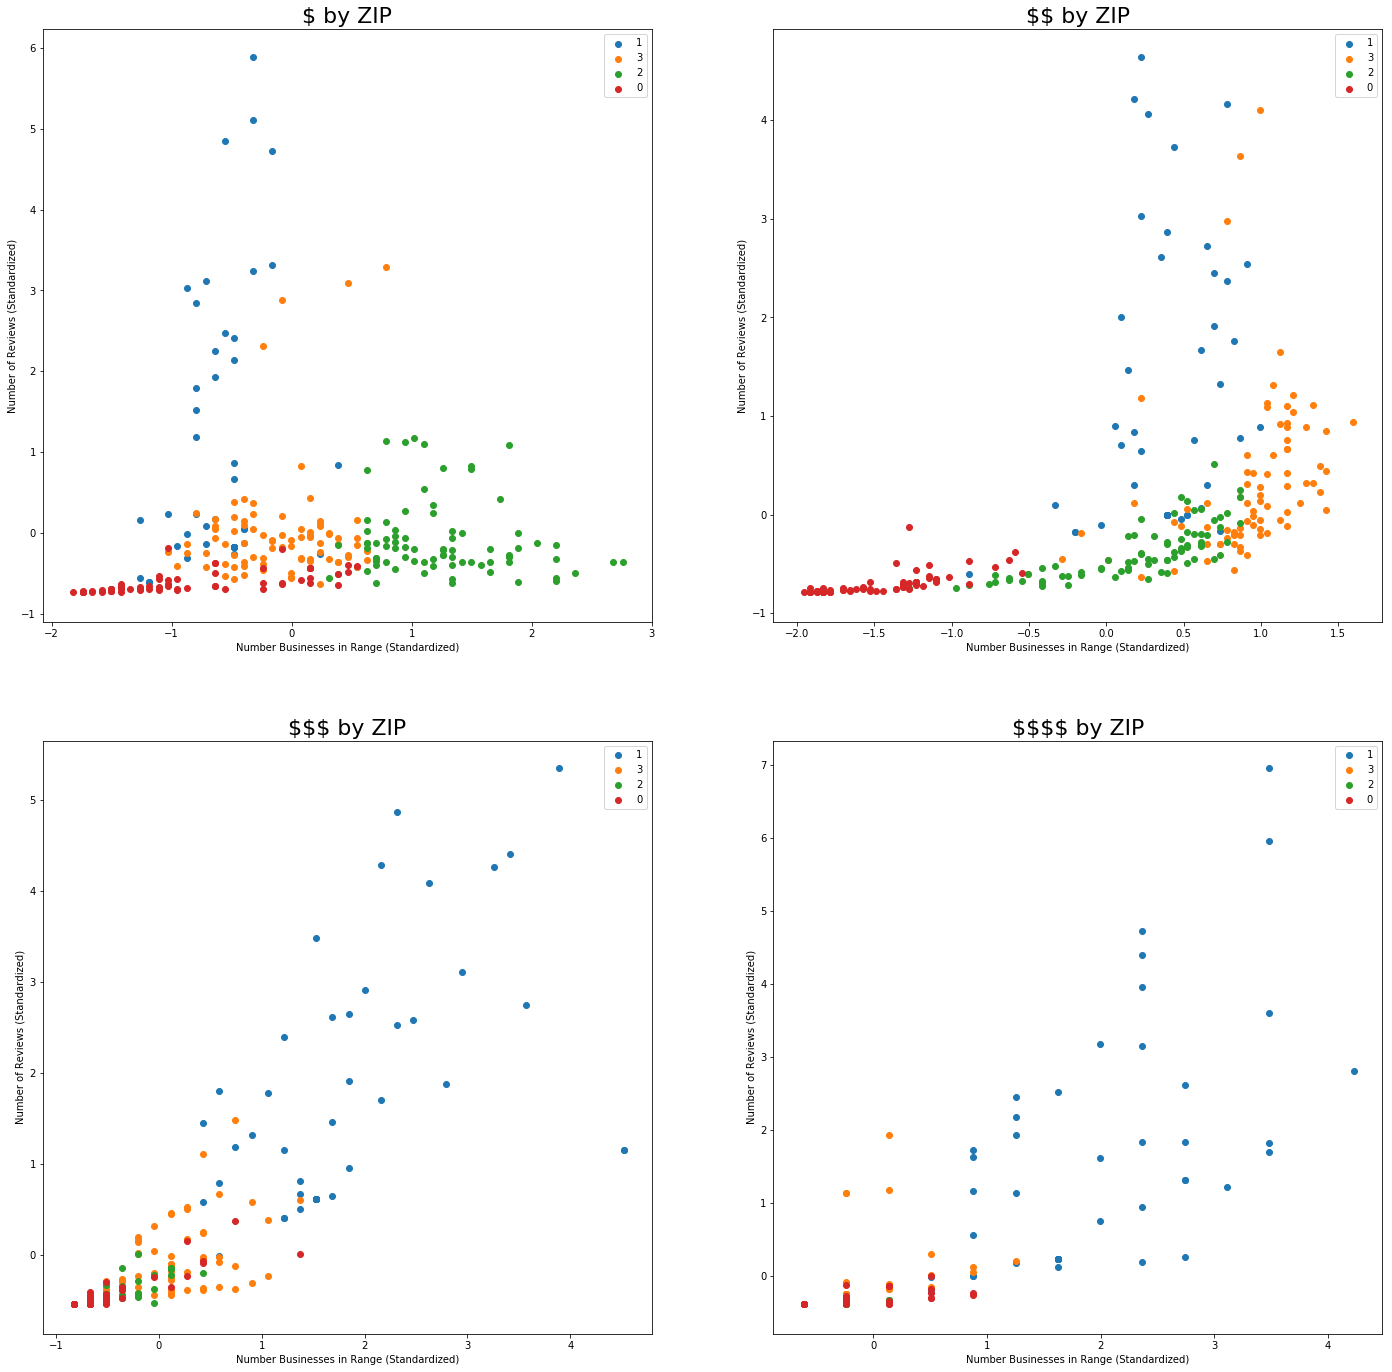

In [102]:
## PLOTS NUMBER OF REVIEWS VS NUMBER OF $ PRICE COUNTS
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()
predicted_data_col = data['kmeans4scaled_pr_mult_wtot']
for i in predicted_data_col.unique():
    ax[0].scatter(data[predicted_data_col==i].pr_1s, data[predicted_data_col==i].rv_1s, label=str(i))
    ax[1].scatter(data[predicted_data_col==i].pr_2s, data[predicted_data_col==i].rv_2s, label=str(i))
    ax[2].scatter(data[predicted_data_col==i].pr_3s, data[predicted_data_col==i].rv_3s, label=str(i))
    ax[3].scatter(data[predicted_data_col==i].pr_4s, data[predicted_data_col==i].rv_4s, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range (Standardized)')
ax[0].set_ylabel('Number of Reviews (Standardized)')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range (Standardized)')
ax[1].set_ylabel('Number of Reviews (Standardized)')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range (Standardized)')
ax[2].set_ylabel('Number of Reviews (Standardized)')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range (Standardized)')
ax[3].set_ylabel('Number of Reviews (Standardized)')
ax[3].legend()

## Latitude Vs Longitude Plot

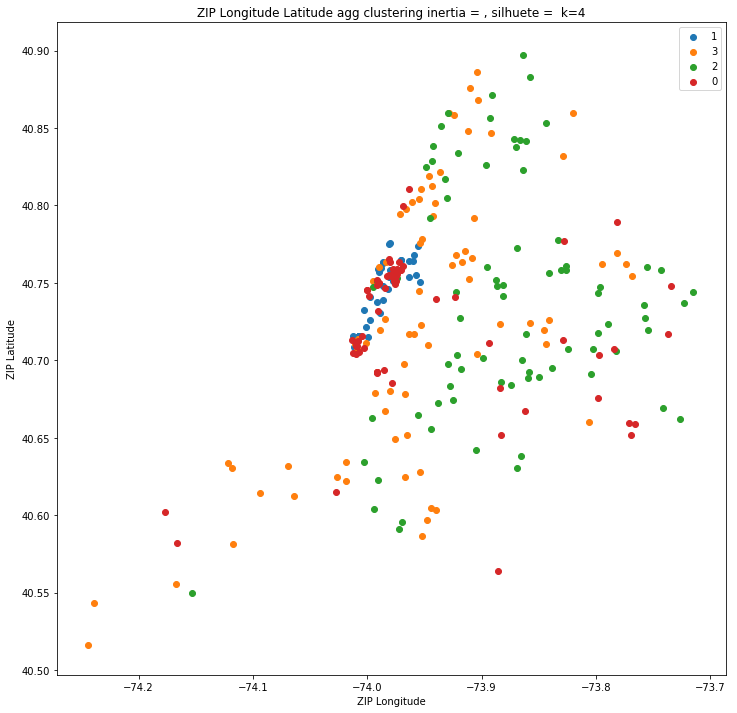

In [88]:
plt.figure(figsize=(12,12))

for i in predicted_data_col.unique():
    plt.scatter(data[predicted_data_col==i].avg_long, data[predicted_data_col==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude agg clustering inertia = , silhuete =  k=4')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()